# Exercise 03: Understanding Log Loss by Breaking It

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shang-vikas/series1-coding-exercises/blob/main/exercises/blog-03/exercise-03.ipynb)

## Setup

In [1]:
# Install required packages using the kernel's Python interpreter
import sys
import subprocess
import importlib

def install_if_missing(package, import_name=None):
    """Install package if it's not already installed."""
    if import_name is None:
        import_name = package

    try:
        importlib.import_module(import_name)
        print(f"✓ {package} is already installed")
    except ImportError:
        print(f"Installing {package}....")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} installed successfully")

# Install required packages
install_if_missing("numpy")
install_if_missing("matplotlib")

✓ numpy is already installed
✓ matplotlib is already installed


## 🧪 Exercise — Understanding Log Loss by Breaking It

We're going to:

- Compute log loss manually.
- Compare it with accuracy.
- Observe how confidence affects penalty.
- See why confident wrong predictions are dangerous.

### Step 1 — Define Log Loss

In [2]:
import numpy as np

def log_loss(p, y):
    # add small epsilon for numerical safety
    eps = 1e-15
    p = np.clip(p, eps, 1 - eps)
    return -(y * np.log(p) + (1 - y) * np.log(1 - p))

### Step 2 — Observe Behavior When True Label = 1

In [3]:
y = 1  # actual class is spam

probs = [0.99, 0.9, 0.5, 0.1, 0.01]

for p in probs:
    print(f"p={p:.2f}  loss={log_loss(p, y):.4f}")

p=0.99  loss=0.0101
p=0.90  loss=0.1054
p=0.50  loss=0.6931
p=0.10  loss=2.3026
p=0.01  loss=4.6052


**What to Notice**

- High confidence correct → tiny loss
- Medium confidence → moderate loss
- Confident wrong → huge loss

**Ask yourself:**

Why should 0.01 be punished more than 0.1?

Because 0.01 means the model is very sure and very wrong.

### Step 3 — Compare With Accuracy

In [4]:
def accuracy(p, y):
    return int((p > 0.5) == y)

for p in probs:
    print(f"p={p:.2f}  accuracy={accuracy(p, y)}  loss={log_loss(p, y):.4f}")

p=0.99  accuracy=1  loss=0.0101
p=0.90  accuracy=1  loss=0.1054
p=0.50  accuracy=0  loss=0.6931
p=0.10  accuracy=0  loss=2.3026
p=0.01  accuracy=0  loss=4.6052


**Observe**

- 0.9 and 0.99 → same accuracy
- 0.1 and 0.01 → same accuracy
- But loss is very different

Accuracy has no gradient.
Loss does.

### Step 4 — Flip the Label (True Label = 0)

In [5]:
y = 0  # actual class is NOT spam

for p in probs:
    print(f"p={p:.2f}  loss={log_loss(p, y):.4f}")

p=0.99  loss=4.6052
p=0.90  loss=2.3026
p=0.50  loss=0.6931
p=0.10  loss=0.1054
p=0.01  loss=0.0101


**Observe symmetry.**

Confident wrong predictions always explode.

### Step 5 — Visualize It

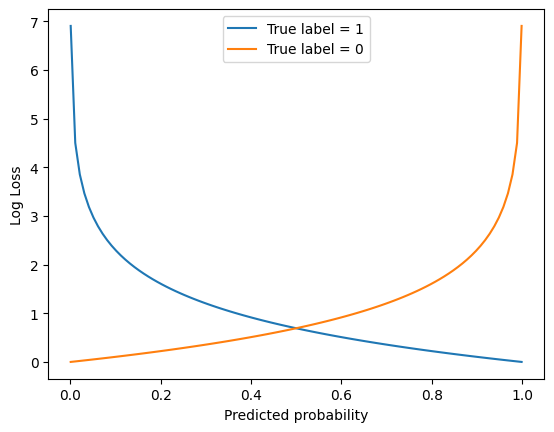

In [6]:
import matplotlib.pyplot as plt

p_values = np.linspace(0.001, 0.999, 100)
loss_y1 = [log_loss(p, 1) for p in p_values]
loss_y0 = [log_loss(p, 0) for p in p_values]

plt.plot(p_values, loss_y1, label="True label = 1")
plt.plot(p_values, loss_y0, label="True label = 0")
plt.xlabel("Predicted probability")
plt.ylabel("Log Loss")
plt.legend()
plt.show()

Look at the curve.

It explodes near 0 or 1 when prediction contradicts truth.

That steep slope is what drives strong gradient updates.

## 🧠 What You Just Learned

- Log loss punishes confident wrong answers aggressively.
- It distinguishes between "barely correct" and "very confident correct."
- It provides smooth gradients.
- It creates strong corrective signals.

## 🔍 Reflection Questions (for Readers)

- Why would using plain accuracy fail for gradient descent?
- Why is exploding loss near 0 or 1 useful?
- What happens if your model outputs exactly 0 or 1?

(Hint: that's why we clip probabilities.)

## 🧱 Final Mental Model

```
logits → sigmoid → probability → log loss → scalar error
```

Log loss turns probability into a smooth "wrongness" signal.

That signal drives gradient descent.

That's the entire training engine.

## 🧪 Exercise — Multi-Class Log Loss (Softmax + Cross-Entropy)

We'll simulate a 3-class classification problem:

**Example classes:**

- 0 → Cat
- 1 → Dog
- 2 → Horse

The model outputs raw scores (logits).
We convert them to probabilities using softmax.
Then compute cross-entropy loss.

### Step 1 — Define Softmax

In [7]:
import numpy as np

def softmax(logits):
    # numerical stability trick
    logits = logits - np.max(logits)
    exp = np.exp(logits)
    return exp / np.sum(exp)

### Step 2 — Define Cross-Entropy Loss

For multi-class:

**Loss = - log(probability_of_true_class)**

**Implementation:**

In [8]:
def cross_entropy(probs, y_true_index):
    return -np.log(probs[y_true_index])

### Step 3 — Example 1 (Reasonably Confident & Correct)

In [9]:
logits = np.array([2.0, 1.0, 0.1])  # raw model scores
probs = softmax(logits)

y_true = 0  # correct class is "Cat"

loss = cross_entropy(probs, y_true)

print("Probabilities:", probs)
print("Loss:", loss)

Probabilities: [0.65900114 0.24243297 0.09856589]
Loss: 0.4170300162778335


**Observe:**

- Class 0 should have highest probability.
- Loss should be small.

### Step 4 — Example 2 (Confident but Wrong)

In [10]:
logits = np.array([0.1, 3.0, 0.2])
probs = softmax(logits)

y_true = 0  # still Cat

loss = cross_entropy(probs, y_true)

print("Probabilities:", probs)
print("Loss:", loss)

Probabilities: [0.04931133 0.89619123 0.05449744]
Loss: 3.0096014645214653


**Now:**

- Model is very confident about Dog.
- True class is Cat.
- Loss becomes large.

This is intentional.

## 🔍 What Softmax Is Doing

Softmax converts raw scores into a probability distribution:

**z → exp(z_i) / Σ exp(z_j)**

**ASCII flow:**

```
logits (z1, z2, z3)
        │
        ▼
     softmax
        │
        ▼
   probabilities (p1, p2, p3)
        │
        ▼
cross-entropy
        │
        ▼
   scalar loss
```

## 🧠 Why Cross-Entropy Works

It penalizes only the probability assigned to the true class.

If the model assigns:

- 0.9 to the true class → small loss
- 0.5 → moderate loss
- 0.01 → huge loss

Exactly like binary log loss.

Same principle. More classes.

### 📊 Visualize the Effect of Confidence

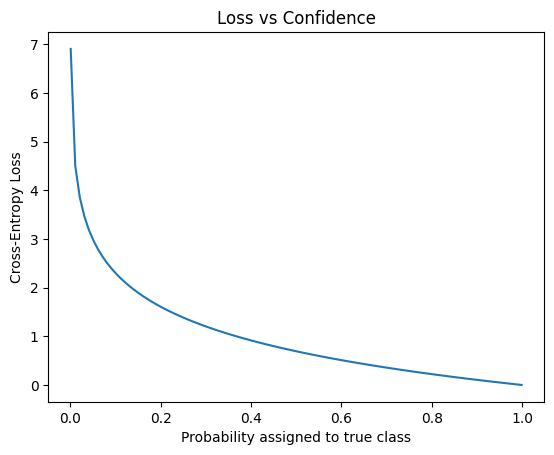

In [11]:
import matplotlib.pyplot as plt

p_values = np.linspace(0.001, 0.999, 100)
loss_values = -np.log(p_values)

plt.plot(p_values, loss_values)
plt.xlabel("Probability assigned to true class")
plt.ylabel("Cross-Entropy Loss")
plt.title("Loss vs Confidence")
plt.show()

Same shape as binary log loss.

Explodes near zero.

## 🧠 Reflection Questions

- Why do we apply softmax before cross-entropy?
- Why not just use accuracy?
- What happens if the model assigns probability 1.0 to the wrong class?

## 🔥 Engineer Takeaway

**Binary case:**

```
sigmoid → log loss
```

**Multi-class case:**

```
softmax → cross-entropy
```

Different surface.
Same engine.

Logarithm penalizes confident wrong predictions.
Gradients use that penalty to adjust weights.

## Key Insight

**Cross-entropy is just log loss applied to the probability assigned to the correct class.**